In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

import seaborn as sns

import datetime

from warnings import filterwarnings
filterwarnings("ignore")

from math import sqrt, floor

from statsmodels.graphics.tsaplots\
    import plot_acf, plot_pacf
from statsmodels.tsa.seasonal\
    import seasonal_decompose
from statsmodels.tsa.stattools\
    import adfuller as ADF

from scipy.stats import\
    ttest_ind as t_Test,\
    f_oneway as f_Test

from sklearn.metrics import\
    mean_squared_error as MSE,\
    mean_absolute_error as MAE,\
    r2_score as R2

In [2]:
actualDF = pd.read_csv("DW_prayer_times.csv")

actualDF = actualDF[
    ["date","esolat_fajr","esolat_zuhr","esolat_asr","esolat_maghrib","esolat_isha"]
]
actualDF["date"] = pd.to_datetime(actualDF["date"]).dt.date

actualDF

,date,esolat_fajr,esolat_zuhr,esolat_asr,esolat_maghrib,esolat_isha
0,2018-01-01,358,799,1002,1156,1230
1,2018-01-02,358,800,1002,1156,1231
2,2018-01-03,359,800,1003,1157,1231
3,2018-01-04,359,801,1003,1157,1232
4,2018-01-05,360,801,1004,1158,1232
...,...,...,...,...,...,...
2917,2025-12-27,364,797,1000,1154,1229
2918,2025-12-28,364,798,1000,1155,1229
2919,2025-12-29,365,798,1001,1155,1230
2920,2025-12-30,365,799,1001,1156,1230


<h2>Normalize or Standardize Data?</h2>
<ul>
    <li>If data follows normal distribution, then standardize data</li>
    <li>Else, normalize data</li>
</ul>

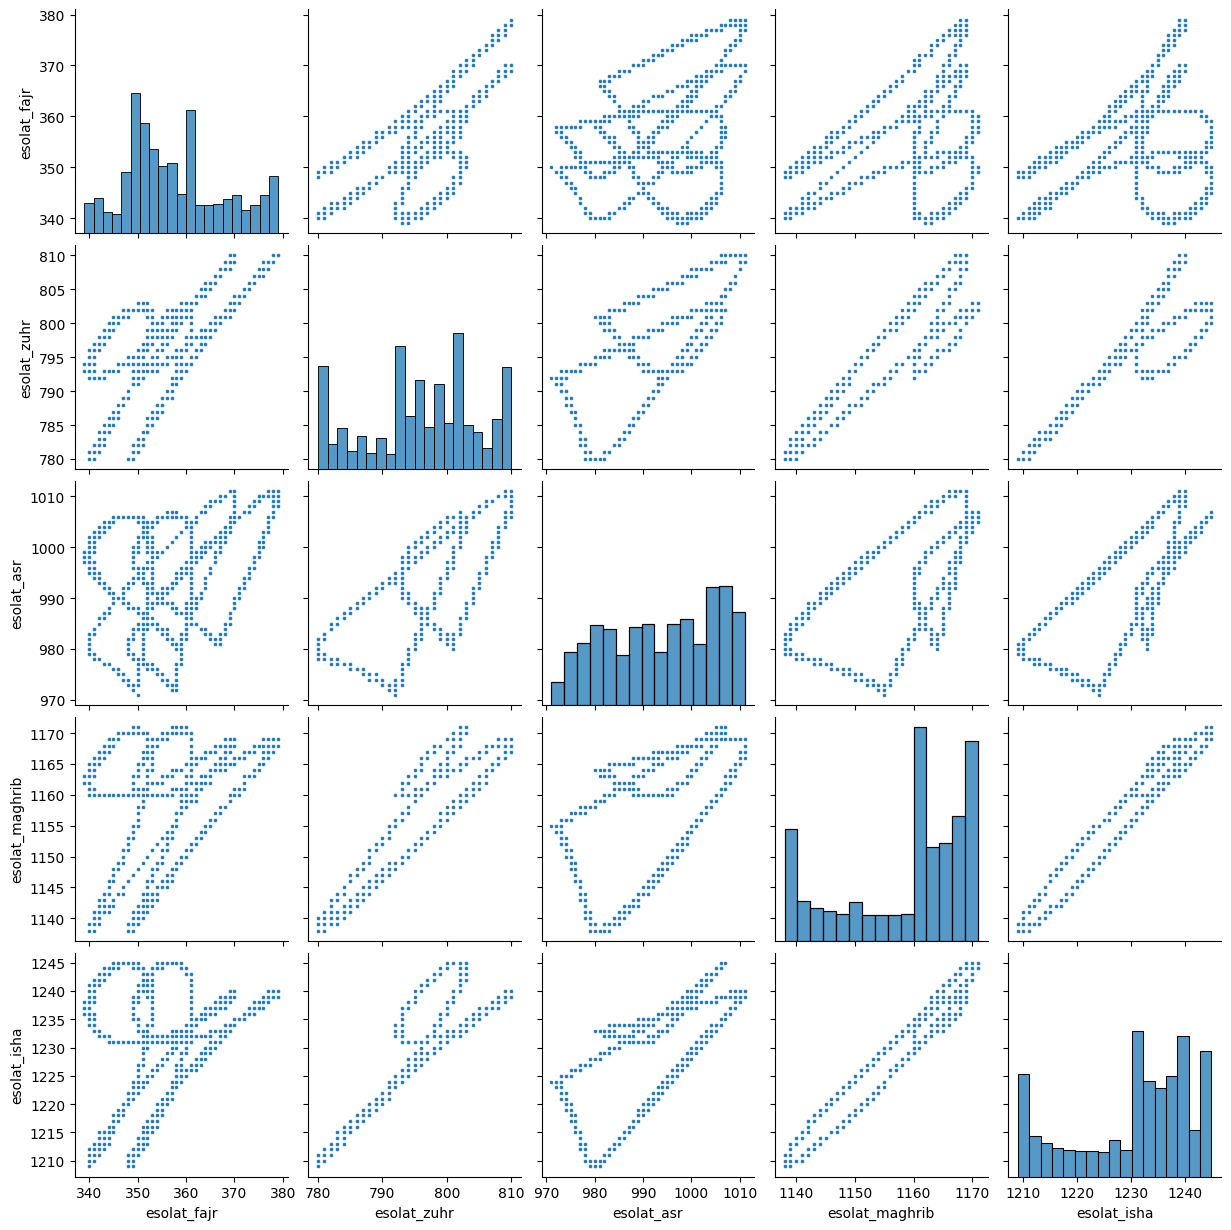

In [3]:
sns.pairplot(
    actualDF,
    vars=["esolat_fajr","esolat_zuhr","esolat_asr","esolat_maghrib","esolat_isha"],
    markers="."
)
plt.show()

Data does not follow normal distribution. Hence, normalize data.

In [4]:
normalizedDF = actualDF.copy()

for column in normalizedDF.columns:
    if column == "date":
        continue

    DataToMin = normalizedDF[column] - normalizedDF[column].min()
    MaxToMin = normalizedDF[column].max() - normalizedDF[column].min()

    normalizedDF[column] = DataToMin / MaxToMin

In [5]:
print(normalizedDF.head())
print(normalizedDF.tail())

         date  esolat_fajr  esolat_zuhr  esolat_asr  esolat_maghrib  \
0  2018-01-01        0.475     0.633333       0.775        0.545455   
1  2018-01-02        0.475     0.666667       0.775        0.545455   
2  2018-01-03        0.500     0.666667       0.800        0.575758   
3  2018-01-04        0.500     0.700000       0.800        0.575758   
4  2018-01-05        0.525     0.700000       0.825        0.606061   

   esolat_isha  
0     0.583333  
1     0.611111  
2     0.611111  
3     0.638889  
4     0.638889  
            date  esolat_fajr  esolat_zuhr  esolat_asr  esolat_maghrib  \
2917  2025-12-27        0.625     0.566667       0.725        0.484848   
2918  2025-12-28        0.625     0.600000       0.725        0.515152   
2919  2025-12-29        0.650     0.600000       0.750        0.515152   
2920  2025-12-30        0.650     0.633333       0.750        0.545455   
2921  2025-12-31        0.675     0.633333       0.775        0.545455   

      esolat_isha  
2917  

<h2>Data Modeling</h2>

<h4>Train and Test sets</h4>
<table>
    <tbody>
        <tr>
            <td><b>Label</b></td>
            <td><b>Percentage</b></td>
            <td><b>Date/Year Range</b></td>
        </tr>
        <tr>
            <td>Train</td>
            <td>75.0</td>
            <td>2018 - 2023</td>
        </tr>
        <tr>
            <td>Validation</td>
            <td>12.5</td>
            <td>2024</td>
        </tr>
        <tr>
            <td>Test</td>
            <td>12.5</td>
            <td>2025</td>
        </tr>
    </tbody>
</table>

In [6]:
start_validation = datetime.date(2024, 1, 1)
start_test = datetime.date(2025, 1, 1)

In [7]:
train = normalizedDF.loc[normalizedDF["date"] < start_validation]
print(train.head())
print(train.tail())

         date  esolat_fajr  esolat_zuhr  esolat_asr  esolat_maghrib  \
0  2018-01-01        0.475     0.633333       0.775        0.545455   
1  2018-01-02        0.475     0.666667       0.775        0.545455   
2  2018-01-03        0.500     0.666667       0.800        0.575758   
3  2018-01-04        0.500     0.700000       0.800        0.575758   
4  2018-01-05        0.525     0.700000       0.825        0.606061   

   esolat_isha  
0     0.583333  
1     0.611111  
2     0.611111  
3     0.638889  
4     0.638889  
            date  esolat_fajr  esolat_zuhr  esolat_asr  esolat_maghrib  \
2186  2023-12-27        0.625     0.566667       0.700        0.484848   
2187  2023-12-28        0.625     0.566667       0.725        0.484848   
2188  2023-12-29        0.650     0.600000       0.725        0.515152   
2189  2023-12-30        0.650     0.600000       0.750        0.515152   
2190  2023-12-31        0.675     0.633333       0.750        0.545455   

      esolat_isha  
2186  

In [8]:
validation_mask = (normalizedDF["date"] >= start_validation) & (normalizedDF["date"] < start_test)
validation = normalizedDF.loc[validation_mask]
print(validation.head())
print(validation.tail())

            date  esolat_fajr  esolat_zuhr  esolat_asr  esolat_maghrib  \
2191  2024-01-01        0.675     0.633333       0.775        0.545455   
2192  2024-01-02        0.700     0.666667       0.775        0.575758   
2193  2024-01-03        0.700     0.666667       0.800        0.575758   
2194  2024-01-04        0.725     0.700000       0.800        0.606061   
2195  2024-01-05        0.725     0.700000       0.825        0.606061   

      esolat_isha  
2191     0.611111  
2192     0.611111  
2193     0.638889  
2194     0.638889  
2195     0.666667  
            date  esolat_fajr  esolat_zuhr  esolat_asr  esolat_maghrib  \
2552  2024-12-27        0.625     0.566667       0.725        0.484848   
2553  2024-12-28        0.650     0.600000       0.725        0.515152   
2554  2024-12-29        0.650     0.600000       0.750        0.515152   
2555  2024-12-30        0.675     0.633333       0.750        0.545455   
2556  2024-12-31        0.675     0.633333       0.775        0.5

In [9]:
test = normalizedDF.loc[normalizedDF["date"] > start_test]
print(test.head())
print(test.tail())

            date  esolat_fajr  esolat_zuhr  esolat_asr  esolat_maghrib  \
2558  2025-01-02        0.700     0.666667       0.800        0.575758   
2559  2025-01-03        0.725     0.700000       0.800        0.606061   
2560  2025-01-04        0.725     0.700000       0.825        0.606061   
2561  2025-01-05        0.750     0.700000       0.825        0.636364   
2562  2025-01-06        0.750     0.733333       0.825        0.636364   

      esolat_isha  
2558     0.638889  
2559     0.638889  
2560     0.666667  
2561     0.666667  
2562     0.666667  
            date  esolat_fajr  esolat_zuhr  esolat_asr  esolat_maghrib  \
2917  2025-12-27        0.625     0.566667       0.725        0.484848   
2918  2025-12-28        0.625     0.600000       0.725        0.515152   
2919  2025-12-29        0.650     0.600000       0.750        0.515152   
2920  2025-12-30        0.650     0.633333       0.750        0.545455   
2921  2025-12-31        0.675     0.633333       0.775        0.5

<h4>Build Model</h4>

Bayesian Regularization Neural Network (BRNN)

In [10]:
import torch
from torch import nn, optim

import torchbnn as bnn

In [11]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction="mean", last_layer_only=False)
kl_weight = 0.01

In [12]:
def build_brnn(col_name = ""):
    if col_name not in normalizedDF.columns:
        return
    
    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2922, out_features=1),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=2922)
    )

    optimizer = optim.Adam(model.parameters(), lr=0.01)

    x = torch.tensor(normalizedDF[col_name].index.values, dtype=int).float()
    y = torch.tensor(normalizedDF[col_name].values, dtype=float).float()

    kl_weight = 0.1

    for step in range(1000):
        pre = model(x)
        mse = mse_loss(pre, y)
        kl = kl_loss(model)
        cost = mse + (kl_weight * kl)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    print(f"MSE: {mse.item():0.3f}, KL: {kl.item():0.3f}")

    return model

In [13]:
model_zuhr = build_brnn("esolat_zuhr")

MSE: 0.368, KL: 6.774


Auto-Regressive Integrated Moving Average (ARIMA)

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

In [15]:
def analyze_arima(col_name = "", p = 0, d = 0):
    if col_name not in normalizedDF.columns:
        return

    q = range(0,9)

    params = product(q)
    params_list = list(params)

    results = []
    best_bic = float("inf")
    for param in params_list:
        try:
            model = ARIMA(train[col_name], order=(p,d,param)).fit()
        except ValueError:
            print("WRONG PARAMETERS! : ", param)
            continue

        bic = model.bic
        if bic < best_bic:
            best_model = model
            best_bic = bic
        results.append([param, model.bic])

    results_table = pd.DataFrame(results)
    results_table.columns = ["Parameter q", "BIC"]
    print(results_table.sort_values(by="BIC", ascending=True).head())
    print(best_model.summary())

In [16]:
# from exploratory_data_analysis.ipynb
# p = 1, d = 0
analyze_arima(col_name="esolat_zuhr", p=1, d=0)

  Parameter q           BIC
6        (6,) -12149.422169
4        (4,) -12144.965610
3        (3,) -12073.953792
7        (7,) -12038.473131
8        (8,) -12033.326397
                               SARIMAX Results                                
Dep. Variable:            esolat_zuhr   No. Observations:                 2191
Model:               ARIMA(1, 0, [6])   Log Likelihood                6090.095
Date:                Wed, 11 Dec 2024   AIC                         -12172.191
Time:                        23:27:05   BIC                         -12149.422
Sample:                             0   HQIC                        -12163.869
                               - 2191                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5356      0.218      2.45